<a href="https://colab.research.google.com/github/modouktouray/farm_instrusion_detection/blob/main/inceptionV3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code below demonstrates how to upload ZIP files in Google Colab, extract their contents, and list the extracted files.

In [19]:
# Upload ZIP Files
from google.colab import files
import zipfile
import os

# Unzip the training data
train_zip_path = "train.zip"
test_zip_path = "test.zip"

# Extract training data
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

# Extract testing data
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test')


print("Training data contents:")
print(os.listdir('/content/train'))

print("\nTesting data contents:")
print(os.listdir('/content/test'))

Training data contents:
['train']

Testing data contents:
['test']


Data augmentation by applying a simulated night-time effect to images in a dataset

In [20]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random

# Function to apply a night-time effect to an images
def apply_night_effect(image):
    """
    Simulates a night-time effect by reducing brightness and adding a bluish tint.
    """
    # Reduce brightness
    alpha = 0.6
    beta = -50
    darkened = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Add a bluish tint
    blue_tint = np.zeros_like(darkened)
    blue_tint[:, :, 0] = 50
    night_effect = cv2.addWeighted(darkened, 0.8, blue_tint, 0.2, 0)

    return night_effect

# Paths for input and output directories
train_dir = '/content/train/train'
output_dir = '/content/train_augmented'
os.makedirs(output_dir, exist_ok=True)

# Augment images for each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name}")
    output_class_path = os.path.join(output_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # List all images in the current class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_night_effects = len(image_files) // 2  # Augment 50% of the images

    # Randomly select images for augmentation
    random.shuffle(image_files)
    selected_images = image_files[:num_night_effects]

    # Apply night-time effect
    for img_file in tqdm(selected_images, desc=f"Augmenting {class_name}"):
        img_path = os.path.join(class_path, img_file)
        image = cv2.imread(img_path)

        night_image = apply_night_effect(image)

        # Save the augmented image
        output_path = os.path.join(output_class_path, img_file)
        cv2.imwrite(output_path, night_image)

    # Copy remaining images to the augmented folder
    for img_file in image_files[num_night_effects:]:
        img_path = os.path.join(class_path, img_file)
        output_path = os.path.join(output_class_path, img_file)
        image = cv2.imread(img_path)
        cv2.imwrite(output_path, image)

print("Night-time augmentation complete. Augmented dataset is ready.")


Processing class: humans


Augmenting humans: 100%|██████████| 198/198 [00:00<00:00, 713.21it/s]


Processing class: monkeys


Augmenting monkeys: 100%|██████████| 266/266 [00:05<00:00, 50.94it/s]


Night-time augmentation complete. Augmented dataset is ready.


Visualizes a selection of augmented images from the dataset.

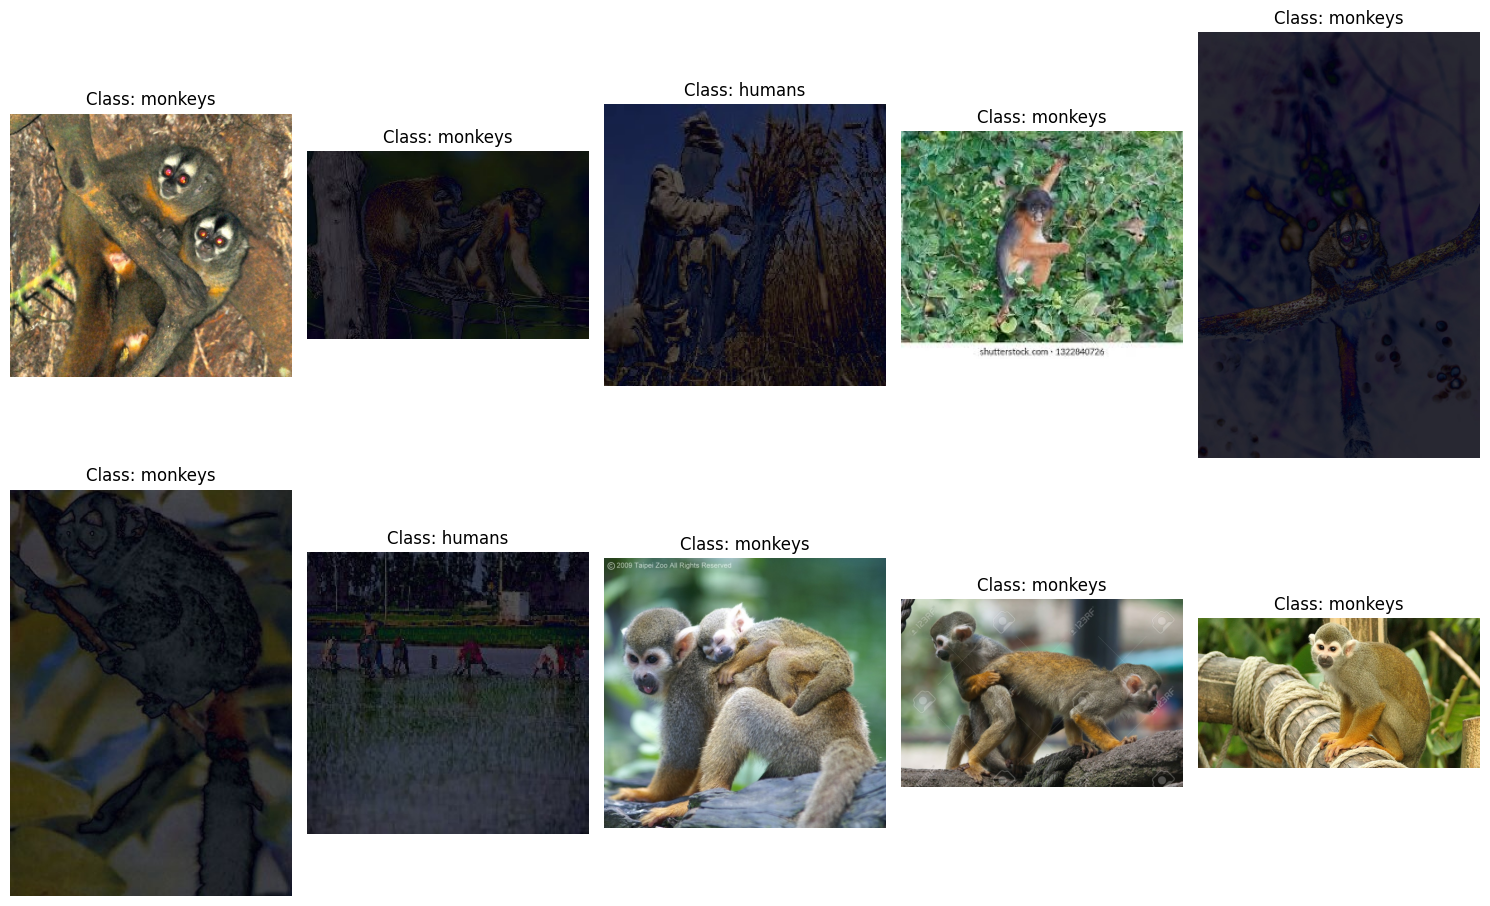

In [29]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Path to the augmented dataset
augmented_dir = '/content/train_augmented'

# Function to load and display images
def display_augmented_images(augmented_dir, num_images=10):
    """
    Display a specified number of randomly selected augmented images from the dataset.
    """
    all_images = []

    # Traverse the augmented dataset and collect file paths
    for class_name in os.listdir(augmented_dir):
        class_path = os.path.join(augmented_dir, class_name)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
            all_images.extend(images)

    # Randomly select images to display
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Display images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        plt.subplot(2, 5, i + 1)  # Create a grid for 10 images
        plt.imshow(img)
        plt.title(f"Class: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display augmented images
display_augmented_images(augmented_dir, num_images=10)


Imports the necessary libraries

In [30]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


Data preprocessing pipeline

In [31]:
# Set Parameters
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 5

# Load and Preprocess Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training data
train_generator = train_datagen.flow_from_directory(
    '/content/train_augmented',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test data
test_generator = test_datagen.flow_from_directory(
    '/content/test/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 929 images belonging to 2 classes.
Found 398 images belonging to 2 classes.


Compiles, and trains model

In [32]:


# Define the Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze the base model layers

# Add a classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train Top Layers Only
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_376 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_376   │ (None, 149, 149, 32)   │             96 │ conv2d_376[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_376            │ (None, 149, 149, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_377 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_376[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_377   │ (None, 147, 147, 32)   │             96 │ conv2d_377[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_377            │ (None, 147, 147, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_378 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_377[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_378   │ (None, 147, 147, 64)   │            192 │ conv2d_378[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_378            │ (None, 147, 147, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 73, 73, 64)     │              0 │ activation_378[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_379 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_379   │ (None, 73, 73, 80)     │            240 │ conv2d_379[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_379            │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_380 (Conv2D)  

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 375s 12s/step - accuracy: 0.7917 - loss: 0.4466 - val_accuracy: 1.0000 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 375s 12s/step - accuracy: 0.9420 - loss: 0.1663 - val_accuracy: 0.9950 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 359s 12s/step - accuracy: 0.9594 - loss: 0.0941 - val_accuracy: 1.0000 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 379s 12s/step - accuracy: 0.9691 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 362s 12s/step - accuracy: 0.9672 - loss: 0.0794 - val_accuracy: 1.0000 - val_loss: 0.0069 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


Testing and evaluation

13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - accuracy: 1.0000 - loss: 0.0066

Test Accuracy: 100.00%
Test Loss: 0.0069
13/13 ━━━━━━━━━━━━━━━━━━━━ 108s 8s/step

Classification Report:
              precision    recall  f1-score   support

      humans       1.00      1.00      1.00       200
     monkeys       1.00      1.00      1.00       198

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



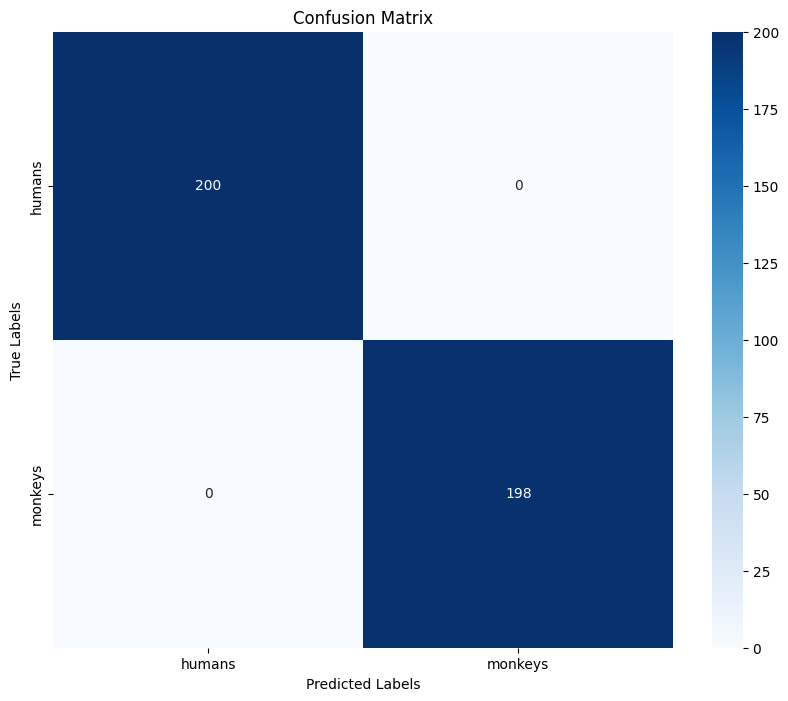

In [33]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate Predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Step 7: Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Step 8: Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Test on a Single Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_image(image_path, model, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    predicted_class = int(prediction > 0.5)
    class_name = class_labels[predicted_class]

    print(f"The image '{image_path}' is predicted as '{class_name}' with confidence {prediction[0][0]:.2f}")
    return class_name

# Example usage of single image prediction
# predict_single_image('/content/test/humans/sample_image.jpg', model, class_labels)


Saving the model

In [23]:
model.save('/content/inceptionV3_model.h5')
print("Model saved as efficientnet_model.h5")

Model saved as efficientnet_model.h5


Visualize the training curves for accuracy and loss

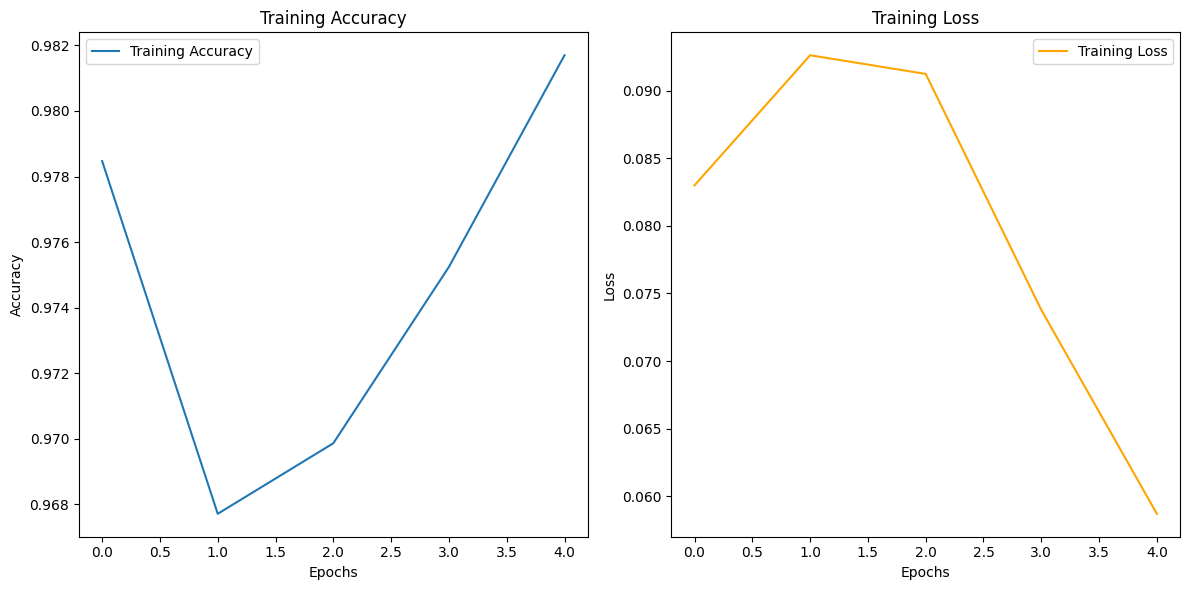

In [34]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    Plot training and validation accuracy and loss curves.

    Args:
        history: Training history object from model.fit().
    """
    # Accuracy plot
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(fine_tune_history)


In [25]:
# Access and print validation loss for each epoch
validation_loss = history.history['val_loss']
print("Validation Loss for each epoch:")
for epoch, loss in enumerate(validation_loss):
    print(f"Epoch {epoch + 1}: {loss}")

Validation Loss for each epoch:
Epoch 1: 0.022862102836370468
Epoch 2: 0.012441129423677921
Epoch 3: 0.009926763363182545
Epoch 4: 0.011406016536056995
Epoch 5: 0.012758634984493256
